In [127]:
import snntorch as snn
import torch
from torch import nn

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from IPython import display
from IPython.display import clear_output, HTML, Video

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.functional import pad

from tqdm import tqdm
from math import sqrt
from random import randint

import os

#!echo '/data' >> .gitignore

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 0

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
print(f"Running on {device}")

Running on cuda


In [129]:
input_rec = []; s1_rec = []; c1_rec = []; s2_rec = []; c2_rec = [];
class snn_hmax(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.counter = 0
        self.num_ker1 = 4
        self.num_ker2 = 4
        self.num_classes = 11
        self.num_capsule_channels = 3
        self.stdp_inshallah = nn.Conv2d(in_channels=10, out_channels=self.num_capsule_channels, kernel_size=3, stride=1, padding=1, groups=1, bias=True)
        self.s1 = nn.Conv2d(in_channels=1, out_channels=self.num_ker1, 
                                     kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.c1 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        self.s2 = nn.Conv2d(in_channels=self.num_ker1, out_channels = self.num_ker2,
                                      kernel_size=4, stride=1, padding=0, bias=True)
        self.c2 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        self.fully_connected1 = nn.Linear(6750, 512)
        self.relu = nn.ReLU()
        self.fully_connected2 = nn.Linear(512, self.num_classes)
        

## vvvvv Utilities vvvvv

In [130]:
class SpikeAnimation():
    def __init__(self, num_plots, color_map = 'coolwarm', frames = None):
        self.to_plot = []
        self.sizes = []
        self.ims = []
        self.color_map = color_map
        self.calc_frames = True
        self.fig, self.axs = plt.subplots(1, num_plots)
        if frames is not None:
            self.frames = frames
            self.calc_frames = False
        return
            
                       
    def add_to_plot(self, three_dim_tensor, size, title):
        assert len(three_dim_tensor.shape) == 3, "Not a three dimensional tensor"
        self.to_plot.append(three_dim_tensor.squeeze(1).detach().numpy())
        self.axs[len(self.to_plot)-1].set_title(title)
        self.sizes.append(size)
        self.ims.append( self.axs[len(self.to_plot)-1].imshow(self.to_plot[-1][0].reshape(size), 
                                      cmap = self.color_map) )
        return
        
    def blit(self, n):
        for iii, image in enumerate(self.ims):
            image.set_array(self.to_plot[iii][n].reshape(self.sizes[iii]))
        return self.ims
    
    def show(self, return_obj=False):
        assert len(self.to_plot) != 0, "No spikes loaded"
        ani = matplotlib.animation.FuncAnimation(self.fig, self.blit, frames = self.frames)
        if return_obj:
            return ani
        return HTML(ani.to_jshtml())

def quick_animate(three_dim_tensor, size, frames, return_obj=False, title=" "):
    temp = SpikeAnimation(max(2, len(three_dim_tensor)), frames=frames)
    for iii in three_dim_tensor:
        temp.add_to_plot(iii, size, f"{title}")
    return temp.show(return_obj)

def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

## Building the network (no stdp)

In [131]:
def pos_neg_to_frame(loader_tensor):
    # combine positive and negative channels of neuromorphic dataset
    return (loader_tensor[:,:,1]-loader_tensor[:,:,0]).movedim(0,1).unsqueeze(2)

In [6]:
HTML("""
<video alt="test" controls id="theVideo">
  <source src="tensor([0.5679]).mp4">
</video>

<script>
video = document.getElementById("theVideo")
video.playbackRate = 0.05;
</script>
""")

In [7]:
a = []

x, targs = next(iter(train_loader))
caps_channel = torch.zeros((batch_size,10,15,15))
x = pos_neg_to_frame(x)[0:100]
#x = pad(x, (0,0,0,0,0,0,0,0,0,100-x.size(0)))

container = torch.zeros((batch_size, len(x), model.num_capsule_channels, 7, 7))
sums = []
print(container.shape)
for iii in range(len(x)):
    y = x[iii]
    y = model.s1(y.to(device))
    w = model.c1(y)
    caps_channel.roll(-1,1)

    caps_channel[:,-1] = w[:, torch.argmax(w.sum((0,2,3)))] #pick most active channel and add it to capsule
    z = model.relu(model.stdp_inshallah(model.relu(caps_channel.to(device))))
    u = model.c2(z)
    
    summ = u.sum((2,3)).mean((0,1))
    a.append((float(summ), iii))
    container[:,iii]=u #z=pooled

#out = container.reshape(container.size(0), -1).to(device)
#out = model.fully_connected1(out)
#out = model.relu(out)
#out = model.fully_connected2(out)
a = sorted(a, reverse=True)
indx = [item[1] for item in a[0:25]]
container = container[:,indx].flatten(1,2)
out = container.reshape(container.size(0), -1).to(device)
out = model.fully_connected1(out)
out = model.relu(out)
out = model.fully_connected2(out)
print(out.shape)
#quick_animate([out.reshape(8,11,1).cpu().detach()], (11,1), 8)

NameError: name 'train_loader' is not defined

In [133]:
@add_to_class(snn_hmax)        
def forward(self, input_spikes, save_plots=False, epoch=0, verbose=False):
    self.output_records = []
    batch_size = input_spikes.shape[1]
    im_width = input_spikes.shape[-1]
    
    container = torch.zeros((batch_size, len(input_spikes), self.num_capsule_channels, 
                             im_width//4-1, im_width//4-1)).to(device)
    caps_channel = torch.zeros((batch_size,10,im_width//2-1,im_width//2-1))
    sums = []

    for jjj, batch_step in enumerate(input_spikes):
        s1_reduced = self.s1(batch_step.to(device)) 
        c1_reduced = self.c1(s1_reduced)
        
        caps_channel = caps_channel.roll(-1,1) #put earliest entry in last to be replaced
        caps_channel[:,-1] = c1_reduced[:,torch.argmax(c1_reduced.sum((0,2,3)))] #pick most active channel

        time_conved = self.stdp_inshallah(self.relu(caps_channel.to(device)))
        pooled = self.c2(time_conved)
        
        summ = pooled.sum((2,3)).mean((0,1))
        sums.append((float(summ), jjj))
        container[:,jjj]=pooled #z=pooled
        if self.counter%50==0:
            if jjj==0:
                s1_rec.append([]); c1_rec.append([]); 
                s2_rec.append([]); c2_rec.append([]);
            s1_rec[-1].append(s1_reduced.cpu().clone())
            c1_rec[-1].append(c1_reduced.cpu().clone())
            s2_rec[-1].append(time_conved.cpu().clone())
            c2_rec[-1].append(pooled.cpu().clone())
    
    sums = sorted(sums, reverse=True)
    indx = [item[1] for item in sums[0:10]]
    container = container[:,indx].flatten(1,2)

    out = container.reshape(container.size(0), -1)
    out = self.fully_connected1(out)
    out = self.relu(out)
    out = self.fully_connected2(out)
    self.output_records.append(out)

    #input_records = torch.stack(input_records)
    #s1_records = torch.stack(s1_records)
    #c1_records = torch.stack(c1_records)
    #s2_records = torch.stack(s2_records)
    #c2_records = torch.stack(c2_records)

    if save_plots:
        print("Saving plots...")
        w = quick_animate([c2_records[:,2,0].cpu().detach(), c2_records[:,3,1].cpu().detach(),
          c2_records[:,4,2].cpu().detach(), c2_records[:,5,3].cpu().detach()], (7,7), len(c2_records), True, f"C2Epoch{epoch}")
        x = quick_animate([s2_records[:,2,0].cpu().detach(), s2_records[:,3,1].cpu().detach(),
          s2_records[:,4,2].cpu().detach(), s2_records[:,5,3].cpu().detach()], (15,15), len(s2_records), True, f"S2Epoch{epoch}")
        y = quick_animate([s1_records[:,0,0].cpu().detach(),s1_records[:,1,0].cpu().detach(),
          s1_records[:,2,0].cpu().detach(), s1_records[:,3,0].cpu().detach()], (30,30), len(s1_records), True, f"S1Epoch{epoch}")
        z = quick_animate([c1_records[:,0,0].cpu().detach(),c1_records[:,1,0].cpu().detach(),
          c1_records[:,2,0].cpu().detach(), c1_records[:,3,0].cpu().detach()], (15,15), len(c1_records), True, f"C1Epoch{epoch}")
        writervideo = matplotlib.animation.FFMpegWriter(fps=60)
        w.save(f'c2recordsE{epoch}.mp4', writer=writervideo)
        x.save(f's2recordsE{epoch}.mp4', writer=writervideo)
        y.save(f's1recordsE{epoch}.mp4', writer=writervideo)
        z.save(f'c1recordsE{epoch}.mp4', writer=writervideo)

    if verbose:
        print(f"t1: {t1.shape}")
        print(f"t2: {t2.shape}")
        print(f"t3: {t3.shape}")
        print(f"pre-stdp: {pre_stdp.shape}")
        print(f"capsule: {capsule.shape}")

    #input: torch.Size([199, 8, 1, 32, 32])
    #t1: torch.Size([8, 1, 32, 32])
    #t2: torch.Size([8, 4, 30, 30])
    #t3: torch.Size([8, 4, 15, 15])
    #pre-stdp: torch.Size([8, 10, 15, 15])
    #capsule: torch.Size([8, 4, 15, 15])

    self.counter = self.counter+1
    self.output_records = torch.stack(self.output_records, dim=0)
    return self.output_records.sum(dim=0)/len(input_spikes)

@add_to_class(snn_hmax)
def __call__(self, spikes_in, save_plots=False, epoch=0, verbose=False):
    return self.forward(spikes_in, save_plots, epoch, verbose)

## Initial training

In [134]:
model = snn_hmax().to(device)

In [135]:
from tqdm import tqdm
import random
import tonic
from tonic import DiskCachedDataset
from torch.utils.data import DataLoader, Subset
import tonic.transforms as transforms

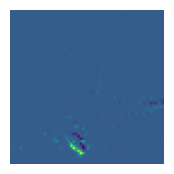

In [137]:
dataset = tonic.datasets.DVSGesture(save_to='./data',
                               train=True)

events, _ = dataset[8]
sensor_size = tonic.datasets.DVSGesture.sensor_size

frame_transform = transforms.Compose([transforms.CropTime(max=2_000_000),
                                      transforms.Downsample(spatial_factor=0.5),
                                      transforms.ToFrame(sensor_size=(64,64,2),
                                                         time_window=10_000)
                                     ])
trainset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

random.seed(seed)
batch_size = 8

subsample_percent = 70

################# DELETE IF USING WHOLE SET
train_subsample_idx = random.sample(range(0, len(trainset)), int(len(trainset)*subsample_percent//100))
test_subsample_idx = random.sample(range(0, len(testset)), int(len(testset)*subsample_percent//100))
trainset = Subset(trainset,  train_subsample_idx)
testset= Subset(testset,  test_subsample_idx)
##########################################

frames = frame_transform(events)
ani = tonic.utils.plot_animation(frames)
HTML(ani.to_jshtml())

In [138]:
cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

cached_dataloader = DataLoader(cached_trainset, batch_size=batch_size)

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=False)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))


In [139]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
from tqdm.auto import tqdm

num_epochs = 7
loss_hist = []
counter = 0
weights = []
# Outer training loop
num_evaluate = 25
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", position=0, leave=True)):  
        labels = labels.to(device)
        # Forward pass
        ims = pos_neg_to_frame(images).to(device)[0:50]
        #ims = pad(ims, (0,0,0,0,0,0,0,0,0,200-ims.size(0)))
        outputs = model(ims)
        loss = criterion(outputs, labels)
        loss_hist.append(loss)
        weights.append(model.stdp_inshallah.weight.cpu().detach().clone())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%50 == 49:
            with torch.no_grad():
                correct = 0
                total = 0
                #print(f"Alpha: {model.alph}, DD {model.past_alph/model.alph}"); model.past_alph = model.alph
                #print(f"Beta: {model.bet}, DD {model.past_beta/model.bet}"); model.past_beta = model.bet
                for j, (test_images, test_labels) in enumerate(tqdm(train_loader, desc="Testing")):
                    if j == num_evaluate:
                        break
                    ims = pos_neg_to_frame(test_images).to(device)[0:50]
                    #ims = pad(ims, (0,0,0,0,0,0,0,0,0,200-ims.size(0)))
                    test_labels = test_labels.to(device)
                    outputs = model(ims)
                    _, predicted = torch.max(outputs.data, 1)
                    total += test_labels.size(0)
                    correct += (predicted == test_labels).sum().item()
                    if j%50==0:
                        #_ = model(ims, save_plots=True, epoch=epoch)
                        print(f"Predicted: {predicted}")
                        print(f"Labels: {test_labels}")
                    
                print(f'Accuracy of the network: {100*correct/total} %')
        #s1_weights.append(model.s1.weight.detach().cpu().clone())
        #s2_weights.append(model.s2.weight.detach().cpu().clone())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

weights = torch.stack(weights)

Epoch 1:   0%|          | 0/95 [00:00<?, ?it/s]

Testing:   0%|          | 0/95 [00:00<?, ?it/s]

Predicted: tensor([9, 4, 1, 1, 3, 3, 7, 1], device='cuda:0')
Labels: tensor([9, 4, 1, 3, 3, 1, 0, 1], device='cuda:0')
Accuracy of the network: 42.5 %
Epoch [1/7], Loss: 3.0418


Epoch 2:   0%|          | 0/95 [00:00<?, ?it/s]

Testing:   0%|          | 0/95 [00:00<?, ?it/s]

Predicted: tensor([9, 4, 1, 1, 3, 3, 7, 1], device='cuda:0')
Labels: tensor([9, 4, 1, 3, 3, 1, 0, 1], device='cuda:0')
Accuracy of the network: 57.0 %
Epoch [2/7], Loss: 0.8843


Epoch 3:   0%|          | 0/95 [00:00<?, ?it/s]

Testing:   0%|          | 0/95 [00:00<?, ?it/s]

Predicted: tensor([9, 4, 1, 1, 3, 1, 7, 1], device='cuda:0')
Labels: tensor([9, 4, 1, 3, 3, 1, 0, 1], device='cuda:0')
Accuracy of the network: 64.5 %
Epoch [3/7], Loss: 0.7526


Epoch 4:   0%|          | 0/95 [00:00<?, ?it/s]

Testing:   0%|          | 0/95 [00:00<?, ?it/s]

Predicted: tensor([9, 4, 1, 1, 3, 1, 0, 1], device='cuda:0')
Labels: tensor([9, 4, 1, 3, 3, 1, 0, 1], device='cuda:0')
Accuracy of the network: 70.5 %
Epoch [4/7], Loss: 0.3821


Epoch 5:   0%|          | 0/95 [00:00<?, ?it/s]

Testing:   0%|          | 0/95 [00:00<?, ?it/s]

Predicted: tensor([9, 4, 1, 1, 3, 1, 0, 1], device='cuda:0')
Labels: tensor([9, 4, 1, 3, 3, 1, 0, 1], device='cuda:0')
Accuracy of the network: 74.5 %
Epoch [5/7], Loss: 0.2314


Epoch 6:   0%|          | 0/95 [00:00<?, ?it/s]

Testing:   0%|          | 0/95 [00:00<?, ?it/s]

Predicted: tensor([9, 4, 1, 1, 3, 1, 0, 1], device='cuda:0')
Labels: tensor([9, 4, 1, 3, 3, 1, 0, 1], device='cuda:0')
Accuracy of the network: 79.5 %
Epoch [6/7], Loss: 4.8718


Epoch 7:   0%|          | 0/95 [00:00<?, ?it/s]

Testing:   0%|          | 0/95 [00:00<?, ?it/s]

Predicted: tensor([9, 4, 1, 1, 3, 1, 0, 1], device='cuda:0')
Labels: tensor([9, 4, 1, 3, 3, 1, 0, 1], device='cuda:0')
Accuracy of the network: 79.5 %


In [ ]:
x = [torch.stack(item).cpu() for item in s1_rec]
x = torch.stack(x[0:len(x)1])
print(x.shape)
quick_animate([x[:,0,0,0], x[:,0,1,0],
              x[:,0,2,0], x[:,0,3,0]], (62,62), len(x))

In [ ]:
y = [torch.stack(item).cpu() for item in c1_rec]
y = torch.stack(y[0:len(y)-1])
print(y.shape)
quick_animate([y[:,0,0,0], y[:,0,1,0],
              y[:,0,2,0], y[:,0,3,0]], (31,31), len(y))

In [ ]:
z = [torch.stack(item).cpu() for item in s2_rec]
z = torch.stack(z[0:len(z)-1])
print(z.shape)
quick_animate([z[:,0,0,0], z[:,0,1,0],
              z[:,0,2,0], z[:,0,3,0]], (31,31), len(z))

In [ ]:
w = [torch.stack(item).cpu() for item in c2_rec]
w = torch.stack(w[0:len(w)-1])
w.shape
quick_animate([w[:,0,0,0], w[:,0,1,0],
              w[:,0,2,0], w[:,0,3,0]], (15,15), len(w))

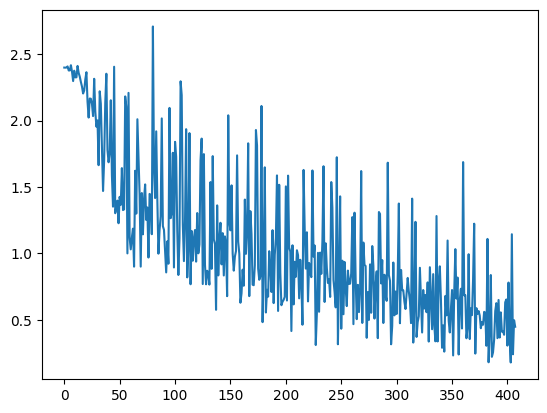

In [118]:
plt.plot([item.cpu().detach().numpy() for item in loss_hist])

## Visualizing Kernels

In [119]:
x = weights
x.shape

torch.Size([408, 3, 10, 3, 3])

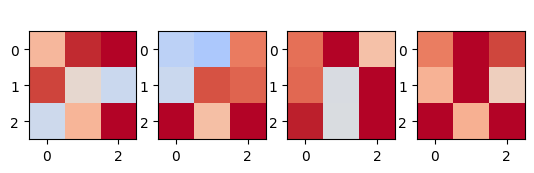

In [120]:
quick_animate([x[:,0,1], x[:,0,4], x[:,0,7], x[:,0,9]], (3,3), 200)

In [ ]:
fig, ax = plt.subplots(3,1)
def animate(jjj):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    
    ax[0].scatter(range(10),x[jjj,0].mean((1,2)))
    ax[1].scatter(range(10),x[jjj,1].mean((1,2)))
    ax[2].scatter(range(10),x[jjj,2].mean((1,2))) 
        
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(x))
HTML(ani.to_jshtml())